In [ ]:
!pip install gcsfs

In [92]:
import pandas as pd
import gcsfs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import itertools

Reading the data files from the google cloud storage

In [93]:
fs = gcsfs.GCSFileSystem(project='omina-gcp-resource')
with fs.open('omina-test-set/occupancy-data/occupancy_data.csv') as f:
    df = pd.read_csv(f)

Changing the date variable to python datetime variable

In [94]:
df['date'] = pd.to_datetime(df['date'])
df.index = df['date']
del df['Unnamed: 0']

Sorting the dataframe by date

In [95]:
df = df.sort_values(by='date')

Creating the NSM variavle and WS variable [NSM stands for Number of seconds since midnight for each day and WS stands for week day (1) or weekend (0)]

In [96]:
df_group = df.groupby(pd.Grouper(key = 'date', freq = 'D'))
df['NSM'] = df.date.apply(lambda x: x - x.replace(hour=0, minute=0, second=0)).dt.total_seconds()
df['WS'] = ((pd.DatetimeIndex(df.index).dayofweek) < 5).astype(int)
del df['date']
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
date,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1,51540.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1,51599.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1,51660.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1,51720.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1,51780.0,1


Generating the correlation table considering the entire data samples

In [97]:
df_corr =df.corr()
df_corr.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy,NSM,WS
Temperature,1.000000,-0.156964,0.688571,0.449989,0.205280,0.555610,0.235422,0.412400
Humidity,-0.156964,1.000000,-0.029459,0.299746,0.932724,0.046240,0.114961,-0.215841
Light,0.688571,-0.029459,1.000000,0.448105,0.223329,0.914850,0.095023,0.267150
CO2,0.449989,0.299746,0.448105,1.000000,0.477965,0.501582,0.127287,0.372715
HumidityRatio,0.205280,0.932724,0.223329,0.477965,1.000000,0.257324,0.201703,-0.051735
Occupancy,0.555610,0.046240,0.914850,0.501582,0.257324,1.000000,0.103522,0.341949
NSM,0.235422,0.114961,0.095023,0.127287,0.201703,0.103522,1.000000,-0.004215


In [98]:
def corrcoef_loop(df): # a function to calculate the associated p-values of correlation
    cols = df.shape[1]
    p = np.zeros(shape=(cols, cols))
    for i in range(cols):
        for j in range(i+1, cols):
            r, p_values = stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
            p[i, j] = p[j, i] = p_values
    return p

Calculate p-values

In [99]:
df1 = df[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']]
df_pval = pd.DataFrame(corrcoef_loop(df1), columns = df1.columns, index = df1.columns)
df_pval.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,NSM,WS
Temperature,0.000000e+00,1.536382e-113,0.000000e+00,0.000000e+00,1.728531e-194,6.865398e-257,0.000000e+00
Humidity,1.536382e-113,0.000000e+00,2.392676e-05,0.000000e+00,0.000000e+00,1.957769e-61,2.745444e-215
Light,0.000000e+00,2.392676e-05,0.000000e+00,0.000000e+00,1.002775e-230,1.881377e-42,0.000000e+00
CO2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.239133e-75,0.000000e+00
HumidityRatio,1.728531e-194,0.000000e+00,1.002775e-230,0.000000e+00,0.000000e+00,1.058240e-187,1.147644e-13
NSM,6.865398e-257,1.957769e-61,1.881377e-42,5.239133e-75,1.058240e-187,0.000000e+00,5.456448e-01
WS,0.000000e+00,2.745444e-215,0.000000e+00,0.000000e+00,1.147644e-13,5.456448e-01,0.000000e+00


Generating training and testing data set based on timeseries splitting

In [100]:
df_train = df['2015-02-04 17:51:00' : '2015-02-10 09:33:00']

In [101]:
df_test = df['2015-02-02 14:19:00' : '2015-02-04 10:43:00']

In [102]:
df_test1 = df['2015-02-11 14:48:00' : '2015-02-18 09:19:00']

Plotting correlations for training dataset

In [105]:
df1 = df_train[['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']]
df_train_corr =df1.corr()
df_train_corr.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,NSM,WS
Temperature,1.000000,-0.141759,0.649942,0.559894,0.151762,0.259958,0.418657
Humidity,-0.141759,1.000000,0.037828,0.439023,0.955198,0.016974,0.108551
Light,0.649942,0.037828,1.000000,0.664022,0.230420,0.085417,0.279519
CO2,0.559894,0.439023,0.664022,1.000000,0.626556,0.209348,0.394834
HumidityRatio,0.151762,0.955198,0.230420,0.626556,1.000000,0.095987,0.243146
NSM,0.259958,0.016974,0.085417,0.209348,0.095987,1.000000,-0.010865
WS,0.418657,0.108551,0.279519,0.394834,0.243146,-0.010865,1.000000


Calculating p-values for training dataset

In [106]:
df_train_pval = pd.DataFrame(corrcoef_loop(df1), columns = df1.columns, index = df1.columns)
df_train_pval.head(7)

,Temperature,Humidity,Light,CO2,HumidityRatio,NSM,WS
Temperature,0.000000e+00,8.045844e-38,0.000000e+00,0.000000e+00,3.731142e-43,6.898404e-126,0.000000e+00
Humidity,8.045844e-38,0.000000e+00,6.396081e-04,0.000000e+00,0.000000e+00,1.256261e-01,8.957692e-23
Light,0.000000e+00,6.396081e-04,0.000000e+00,0.000000e+00,1.384224e-98,1.155777e-14,4.848841e-146
CO2,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.507120e-81,5.602596e-302
HumidityRatio,3.731142e-43,0.000000e+00,1.384224e-98,0.000000e+00,0.000000e+00,3.943321e-18,6.771405e-110
NSM,6.898404e-126,1.256261e-01,1.155777e-14,2.507120e-81,3.943321e-18,0.000000e+00,3.269109e-01
WS,0.000000e+00,8.957692e-23,4.848841e-146,5.602596e-302,6.771405e-110,3.269109e-01,0.000000e+00


In [107]:
feature_names = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'NSM', 'WS']
X_train = df_train[feature_names]
y_train = df_train['Occupancy']
X_test = df_test[feature_names]
y_test = df_test['Occupancy']
X_test1 = df_test1[feature_names]
y_test1 = df_test1['Occupancy']

In [108]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Accuracy of Logistic regression classifier on training set: {:.2f}'.format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.98
Accuracy of Logistic regression classifier on test set: 0.98


In [109]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'.format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'.format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.98
Accuracy of GNB classifier on test set: 0.98


In [110]:
svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'.format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'.format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.64


In [111]:
pred = svm.predict(X_test)
df_CM = pd.DataFrame(confusion_matrix(y_test, pred), columns = ["Predicted 0", "Predicted 1"], index = ["Actual 0", "Actual 1"])
df_CM.head()

,Predicted 0,Predicted 1
Actual 0,1693,0
Actual 1,971,1


In [112]:
class_names = np.array(['0', '1'])

In [129]:
def plot_confusion_matrix(conf_mat, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(conf_mat)

    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes) # , rotation = 45)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = conf_mat.max() / 2.
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        plt.text(j, i, format(conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if conf_mat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1693    0]
 [ 971    1]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


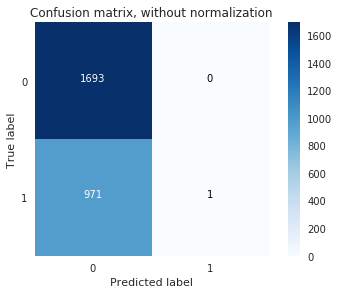

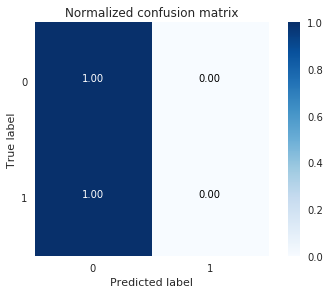

In [131]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(conf_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
scores = []
for val in range (1, 41):
  clf = RandomForestClassifier(n_estimators = val)
  validated = cross_val_score(clf, X_test1, y_test1, cv = 10)
  scores.append(validated)

In [ ]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))